Задача изучить:
откуда приходят пользователи и какими устройствами они пользуются,
сколько стоит привлечение пользователей из различных рекламных каналов;
сколько денег приносит каждый клиент,
когда расходы на привлечение клиента окупаются,
какие факторы мешают привлечению клиентов.


Шаг 2. Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.


Шаг 3. Исследовательский анализ данных

Шаг 4. Маркетинг
Посчитайте общую сумму расходов на маркетинг.

Шаг 5. Оцените окупаемость рекламы

Шаг 6. Напишите выводы


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

    Checking for missing data

In [2]:
print(visits.isna().sum())
print()
print(orders.isna().sum())
print()
print(costs.isna().sum())

User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

User Id     0
Event Dt    0
Revenue     0
dtype: int64

dt         0
Channel    0
costs      0
dtype: int64


    Checking for duplicates

In [3]:
print(visits.duplicated().sum())
print()
print(orders.duplicated().sum())
print()
print(costs.duplicated().sum())

0

0

0


    Checking type of data
    Changed name of columns (lower case and deleted spaces)
    Changed type of columns with date from object type to datetime type

In [4]:
visits.columns = visits.columns.str.lower()
visits = visits.rename(columns={'user id':'user_id', 'session start':'session_start', 'session end':'session_end'})
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits.info()

orders.columns = orders.columns.str.lower()
orders = orders.rename(columns={'user id':'user_id', 'event dt':'event_dt'})
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
#orders.info()

costs.columns = costs.columns.str.lower()
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
#costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [5]:
(
    visits[['session_start', 'session_end']]
    .apply(['count', 'min', 'max'])
)

,session_start,session_end
count,309901,309901
min,2019-05-01 00:00:41,2019-05-01 00:07:06
max,2019-10-31 23:59:23,2019-11-01 01:38:46


In [6]:
(
    orders[['event_dt', 'revenue']]
    .apply(['count', 'min', 'max'])
)

,event_dt,revenue
count,40212,40212.00
min,2019-05-01 00:28:11,4.99
max,2019-10-31 23:56:56,49.99


In [7]:
(
    costs[['dt', 'costs']]
    .apply(['count', 'min', 'max'])
)

,dt,costs
count,1800,1800.0
min,2019-05-01,0.8
max,2019-10-27,630.0


### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [8]:
def get_profiles(visits, orders, ad_costs):
    profiles = (
    visits.sort_values(by=['user_id', 'session_start'])
    .groupby('user_id')
    .agg({'session_start':'first', 'region':'first', 'channel':'first', 'device':'first'})
    .rename(columns={'session_start':'first_ts'})
    .reset_index()
    )
    
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id':'nunique'})
        .rename(columns={'user_id':'unique_users'})
        .reset_index()
    )
    
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']], on=['dt', 'channel'], how='left')
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles

profiles = get_profiles(visits, orders, costs)

In [9]:
def get_retention(profiles, visits, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    
    dimensions = ['payer'] + dimensions
    
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
        
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(visits[['user_id', 'session_start']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        
        cohort_sizes = df.groupby(dims).agg({'user_id':'nunique'}).rename(columns={'user_id':'cohort_size'})
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis = 0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        
        result['cohort_size'] = cohort_sizes
        
        return result
    
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    return result_raw, result_grouped, result_in_time

In [10]:
def get_conversion(profiles, orders, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
        
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    first_purchases = (orders.sort_values(by=['user_id', 'event_dt'])
    .groupby('user_id')
    .agg({'event_dt':'first'})
    .reset_index())
    
    result_raw = result_raw.merge(first_purchases[['user_id', 'event_dt']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        result = result.fillna(0).cumsum(axis = 1)
        
        cohort_sizes = df.groupby(dims).agg({'user_id':'nunique'}).rename(columns={'user_id':'cohort_size'})
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis = 0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        
        result['cohort_size'] = cohort_sizes
        
        return result
    
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    if 'cohort' in dimensions:
        dimensions = []
        
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    return result_raw, result_grouped, result_in_time

In [11]:
def get_ltv(profiles, orders, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
        
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    result_raw = result_raw.merge(orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='revenue', aggfunc='sum')
        result = result.fillna(0).cumsum(axis = 1)
        
        cohort_sizes = (df.groupby(dims).agg({'user_id':'nunique'}).rename(columns={'user_id':'cohort_size'}))
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis = 0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (cac.groupby(dims).agg({'acquisition_cost':'mean'}).rename(columns={'acquisition_cost':'cac'}))
        
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        
        return result, roi
    
    result_grouped, roi_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    if 'cohort' in dimensions:
        dimensions = []
        
    result_in_time, roi_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    return result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time
    

In [12]:
def filter_data(df,window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    
    return df

In [13]:
def plot_retention(retention, retention_history, horizon, window=5):

    plt.figure(figsize=(15, 10))

    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon - 1]]

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    ax3 = plt.subplot(2, 2, 3)
    
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']]
    
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания платящих пользователей на {}-й день'.format(horizon))

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(horizon))
    
    plt.tight_layout()
    plt.show()



In [14]:
def plot_conversion(conversion, conversion_history, horizon, window=5):

    plt.figure(figsize=(15, 5))

    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon - 1]]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [name for name in conversion_history.index.names if name not in ['dt']]
    
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    datetime(2019, 10, 10).date(),
    7,
    dimensions=['channel'],
)


In [15]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=5):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    cac_history = roi_history[['cac']]

    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[[horizon - 1]]

    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean')
    
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

In [16]:
profiles = get_profiles(visits, orders, costs)
display(profiles.head())

prof_min = profiles['first_ts'].min()
prof_max = profiles['first_ts'].max()

display(prof_min, prof_max)

,user_id,first_ts,region,channel,device,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,United States,FaceBoom,Mac,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,United States,FaceBoom,iPhone,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,France,organic,iPhone,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,Germany,AdNonSense,PC,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,United States,YRabbit,iPhone,2019-10-02,2019-10-01,False,0.230769


Timestamp('2019-05-01 00:00:41')

Timestamp('2019-10-27 23:59:04')



<b>Профили пользователей составил, где определил первую дату посещения, регион и устройство, с которого совершен вход. Самый первый пользователь был привлечен 01.05.2019, а самый последний - 27.10.2019.

In [17]:
region_stat = profiles.groupby('region').agg({'user_id':'nunique', 'payer':'mean'}).sort_values(by='user_id',ascending=False)
region_stat['payer'] = region_stat['payer'] * 100
display(region_stat)

,user_id,payer
region,,
United States,100002,6.901862
UK,17575,3.982930
France,17450,3.799427
Germany,14981,4.111875


In [18]:
region_stat = profiles.groupby('device').agg({'user_id':'nunique', 'payer':'mean'}).sort_values(by='payer',ascending=False)
display(region_stat)

,user_id,payer
device,,
Mac,30042,0.063644
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468


In [19]:
region_stat = profiles.groupby('channel').agg({'user_id':'nunique', 'payer':'mean'}).sort_values(by='payer',ascending=False)
display(region_stat)

,user_id,payer
channel,,
FaceBoom,29144,0.122049
AdNonSense,3880,0.113402
lambdaMediaAds,2149,0.104700
TipTop,19561,0.096007
RocketSuperAds,4448,0.079137
WahooNetBanner,8553,0.052964
YRabbit,4312,0.038265
MediaTornado,4364,0.035747
LeapBob,8553,0.030633


### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

In [20]:
comm_cost_ag = pd.pivot_table(costs, index='channel', values='costs', aggfunc='sum', margins=True)
display(comm_cost_ag.sort_values(by='costs', ascending=False))

,costs
channel,
All,105497.30
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60




<b>Как можно видеть из сводной таблицы, общая сумма расходов на рекламу составила 105 497 УЕ. Больше всего денег потратили на TipTop and FaceBoom, меньше всего на MediaTornado and YRabbit

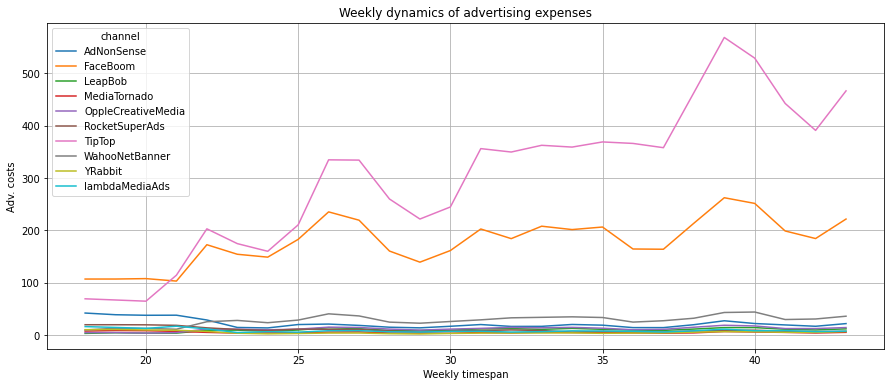

In [21]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].dt.month
costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='mean').plot(grid=True, figsize=(15,6))
plt.ylabel('Adv. costs')
plt.xlabel('Weekly timespan')
plt.title('Weekly dynamics of advertising expenses')
plt.show()



<b>На недельном графике расходов на рекламу видно,  что расходы на TipTop увеличивались постепенно и с интервалом примерно месяц. И только к началу 40 недели стали сокращаться. В источнике FaceBoom расходы на рекламу держались в итервале 150 - 250. Расходы в остальных источниках трафика несущественны. 

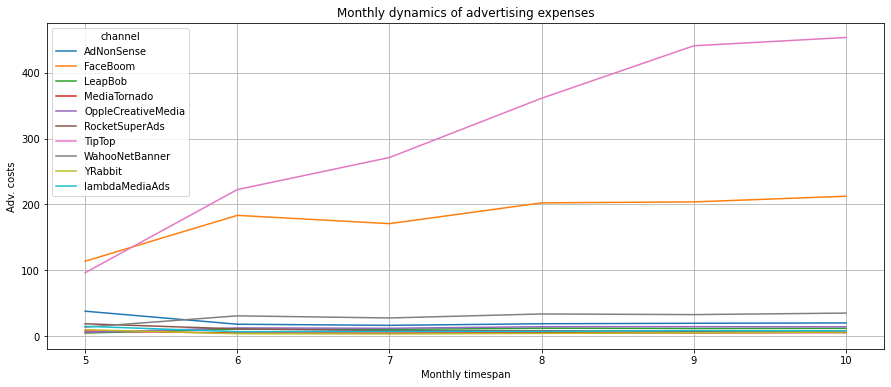

In [22]:
costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='mean').plot(grid=True, figsize=(15,6))
plt.ylabel('Adv. costs')
plt.xlabel('Monthly timespan')
plt.title('Monthly dynamics of advertising expenses')
plt.show()

In [23]:
avg_channel_CAC = profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')
display(avg_channel_CAC.sort_values(by='acquisition_cost', ascending=False))

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717




<b>Средняя стоимость самых дорогих пользователей была в канале TipTop (2.8 YE), далее FaceBoom - 1.1 YE и AdNonSense - 1.0 YE

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

,user_id,first_ts,region,channel,device,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,United States,FaceBoom,Mac,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,United States,FaceBoom,iPhone,2019-07-09,2019-07-01,False,1.107237
3,22593348,2019-08-22 21:35:48,Germany,AdNonSense,PC,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,United States,YRabbit,iPhone,2019-10-02,2019-10-01,False,0.230769
7,46006712,2019-06-30 03:46:29,France,AdNonSense,Android,2019-06-30,2019-06-01,True,1.008000


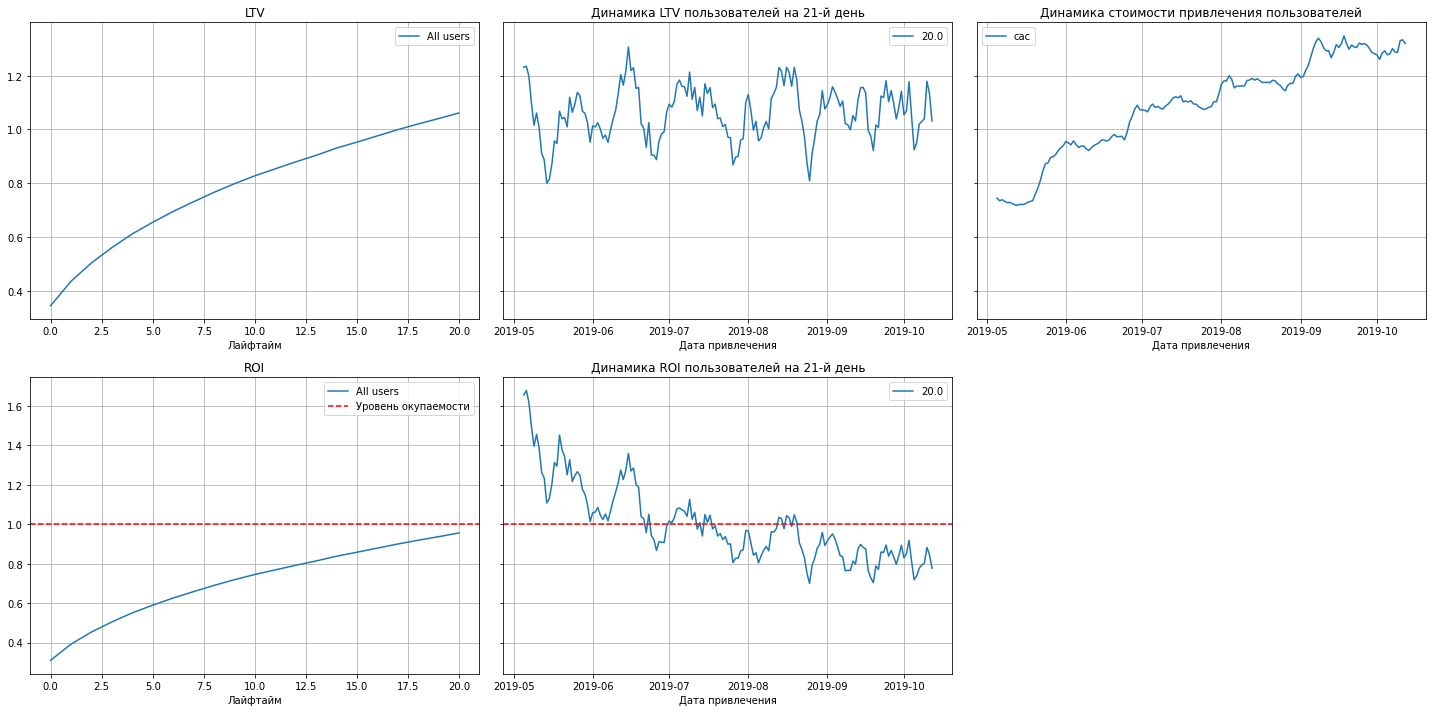

In [24]:
profiles = profiles.query('channel != "organic"')
display(profiles.head())

observation_date = datetime(2019, 11, 1).date()
horizon_days = 21

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon_days)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

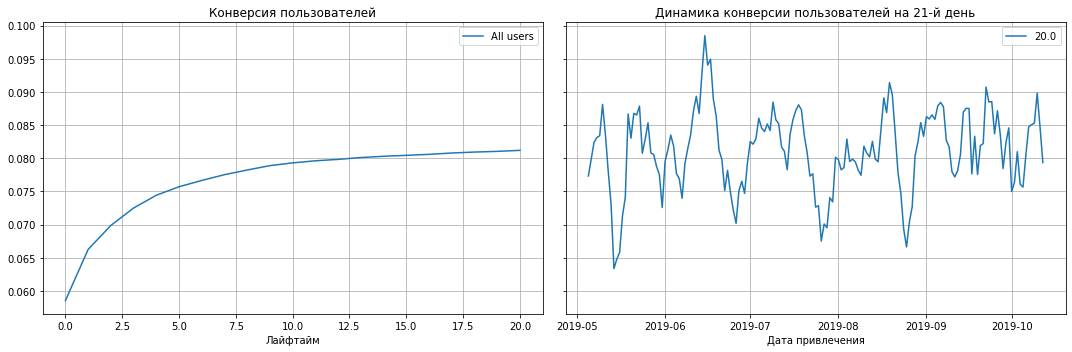

In [25]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

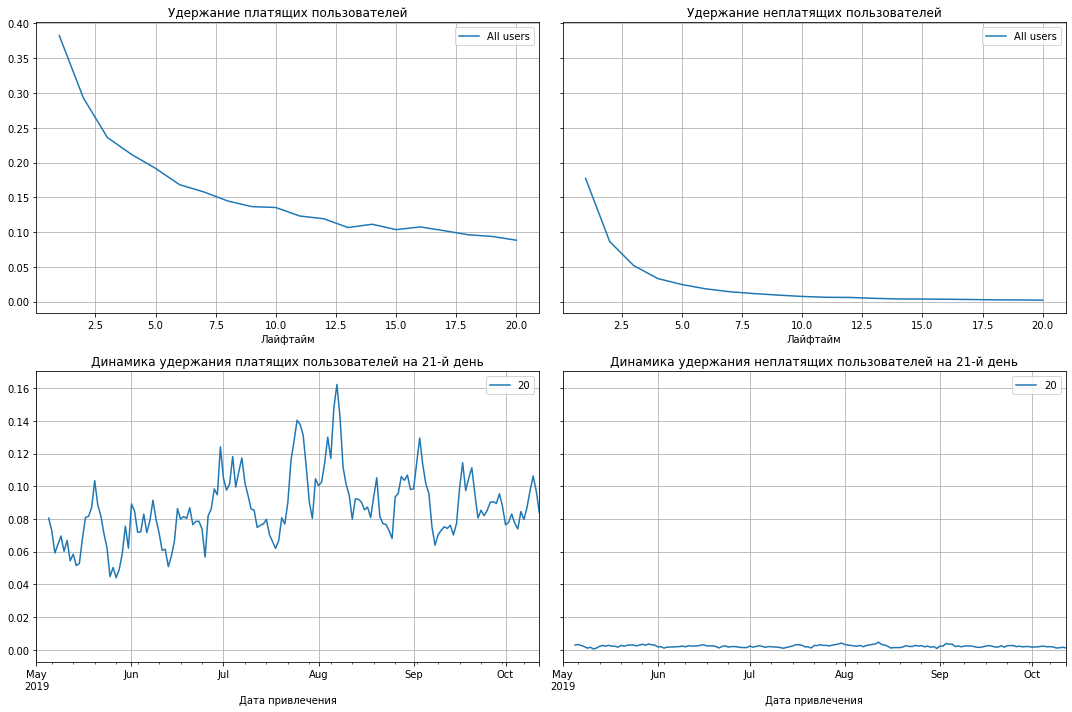

In [26]:
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days)

plot_retention(retention_grouped, retention_history, horizon_days)

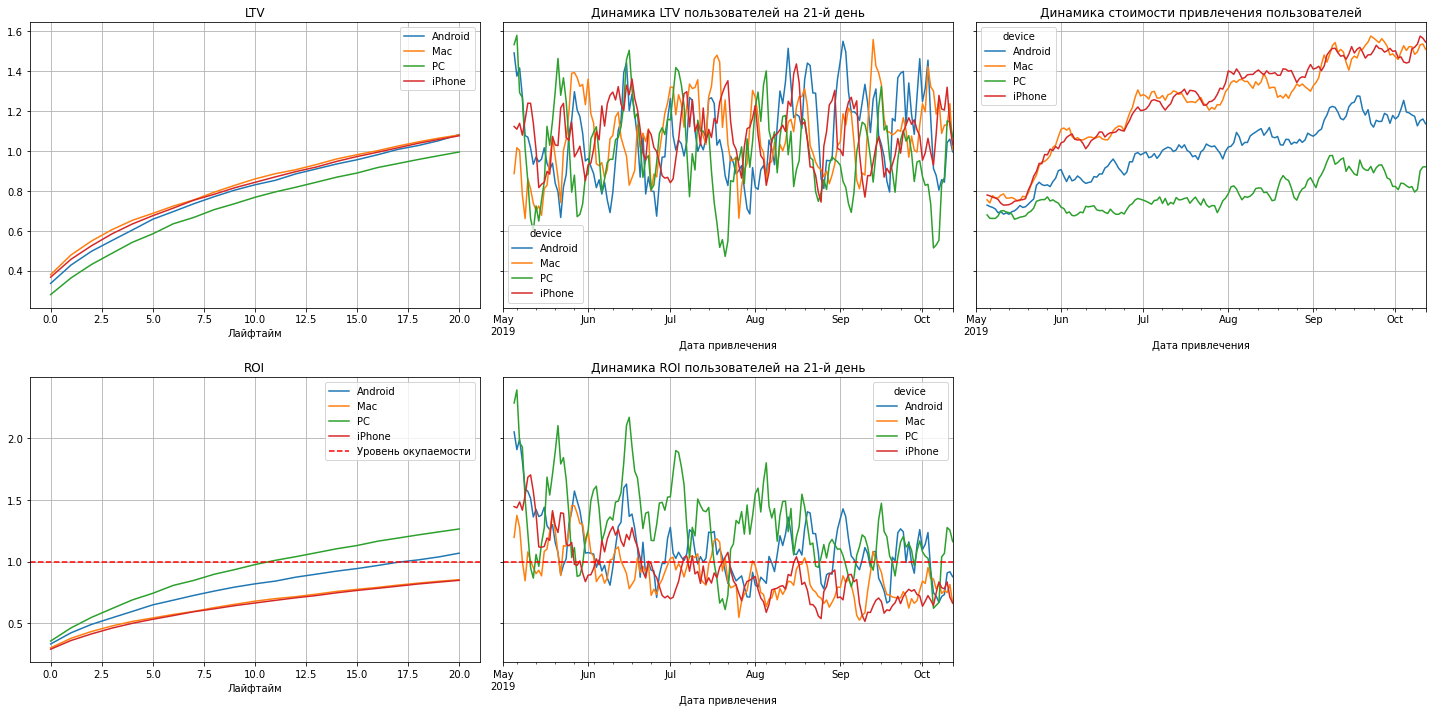

In [27]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon_days, dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

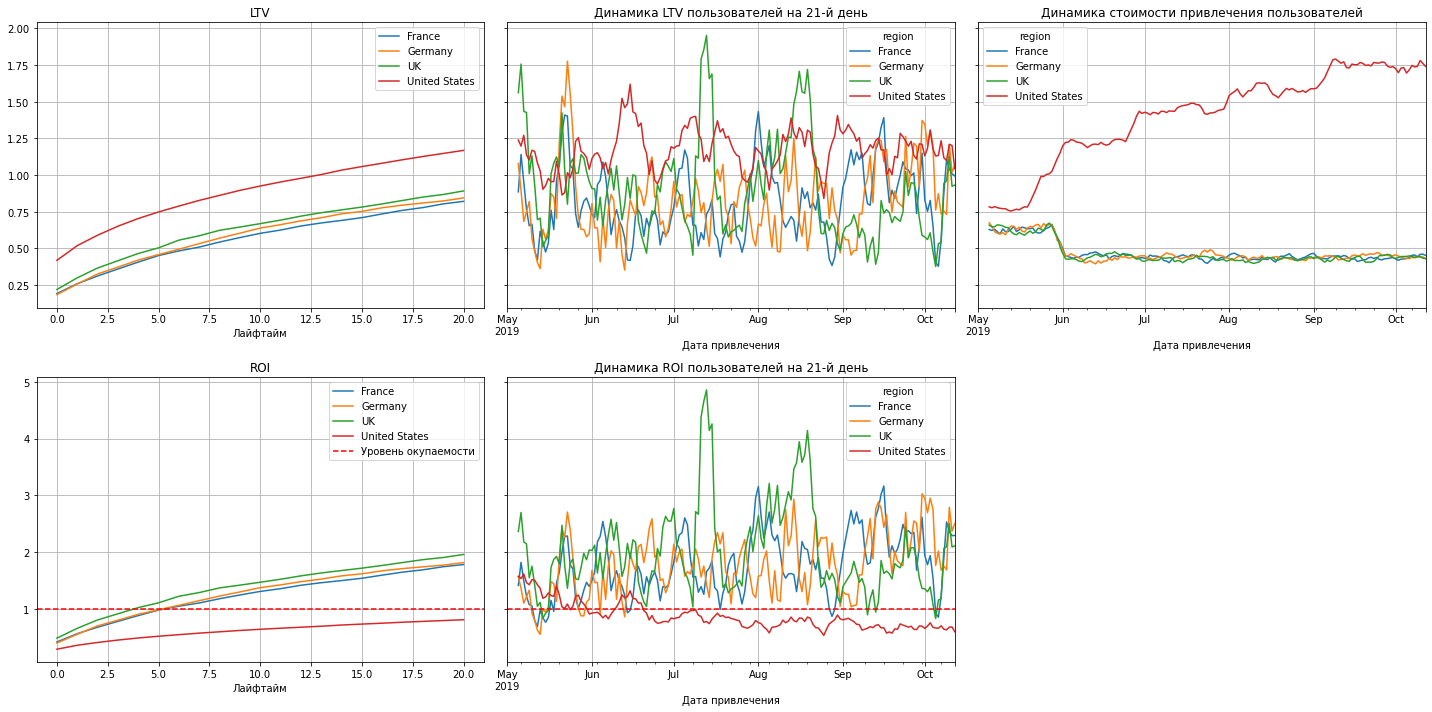

In [28]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon_days, dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

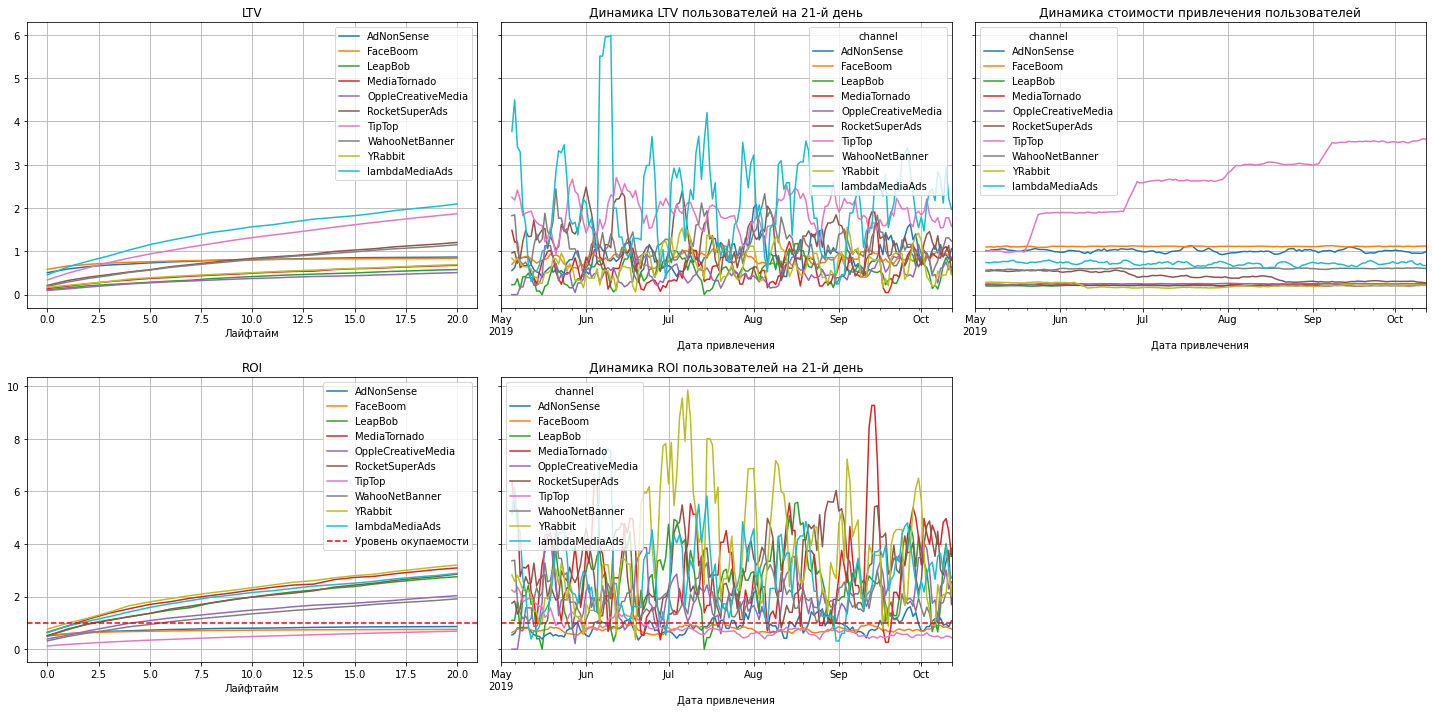

In [29]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon_days, dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

<div class="alert alert-block alert-info">

<b>Общий вывод по пункту 5.
    В целом затраты на рекламу окупаются. но только на 3ю неделю, что не соответствует бизнес-плану компании.
    Негативное влияние оказывает Американский регион, где стоимость привлечения пользователей самая большая, которые не окупаются. Также, большие затраты на канал привлечения TipTop.
    Проблемы с Американским регионом могут быть в плохой маркетинговой компании, возможно использование нецелевой аудитории в каналах привлечения.

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.